<a href="https://colab.research.google.com/github/iliavk/rebalance-portfolio/blob/main/rebalance_simulation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look better
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [13]:
# Download S&P 500 data
sp500_df = yf.download('^GSPC', start='2010-01-01', end='2024-12-31', auto_adjust=True)
sp500 = sp500_df['Close'].resample('ME').last().squeeze()

# Drop NaNs from sp500 just in case (especially early ones)
sp500 = sp500.dropna()

# Simulate constant monthly return (4% annualized)
tbill_monthly_return = (1 + 0.04) ** (1/12) - 1

# Create a Series of monthly T-Bill values starting at 1
tbill_values = (1 + tbill_monthly_return) ** np.arange(len(sp500))
tbill = pd.Series(tbill_values, index=sp500.index)

# Combine into DataFrame
prices = pd.DataFrame({'SP500': sp500, 'TBill': tbill})
prices.head()

[*********************100%***********************]  1 of 1 completed


,SP500,TBill
Date,,
2010-01-31,1073.869995,1.000000
2010-02-28,1104.489990,1.003274
2010-03-31,1169.430054,1.006558
2010-04-30,1186.689941,1.009853
2010-05-31,1089.410034,1.013159


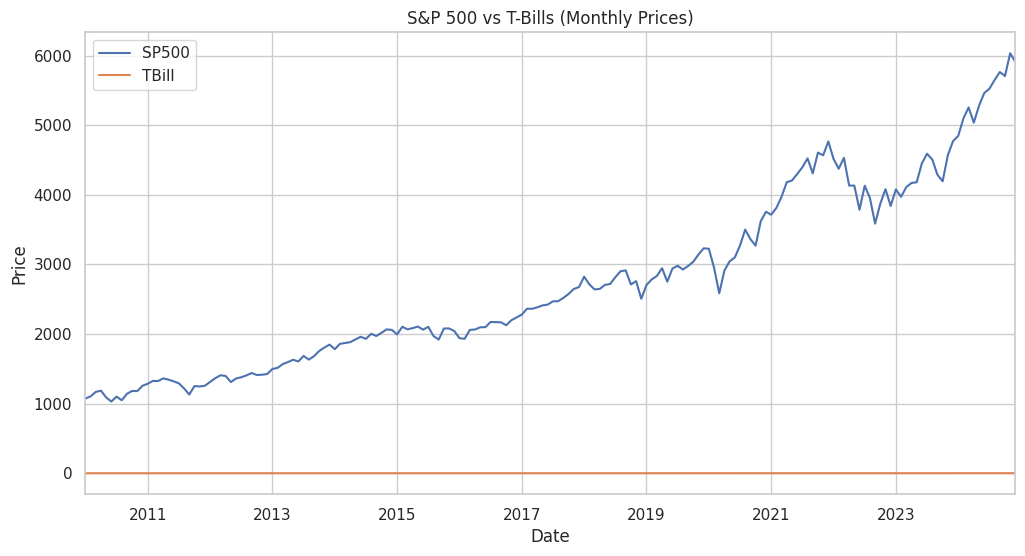

In [14]:
prices.plot(title='S&P 500 vs T-Bills (Monthly Prices)', figsize=(12, 6))
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [15]:
print("Length:", len(sp500))
print(sp500.head(10))

Length: 180
Date
2010-01-31    1073.869995
2010-02-28    1104.489990
2010-03-31    1169.430054
2010-04-30    1186.689941
2010-05-31    1089.410034
2010-06-30    1030.709961
2010-07-31    1101.599976
2010-08-31    1049.329956
2010-09-30    1141.199951
2010-10-31    1183.260010
Freq: ME, Name: ^GSPC, dtype: float64


In [16]:
print("Length:", len(tbill))
print(tbill.head(10))

Length: 180
Date
2010-01-31    1.000000
2010-02-28    1.003274
2010-03-31    1.006558
2010-04-30    1.009853
2010-05-31    1.013159
2010-06-30    1.016476
2010-07-31    1.019804
2010-08-31    1.023142
2010-09-30    1.026492
2010-10-31    1.029852
Freq: ME, dtype: float64


In [17]:
prices = pd.DataFrame({'SP500': sp500, 'TBill': tbill})
print(prices.head(10))

                  SP500     TBill
Date                             
2010-01-31  1073.869995  1.000000
2010-02-28  1104.489990  1.003274
2010-03-31  1169.430054  1.006558
2010-04-30  1186.689941  1.009853
2010-05-31  1089.410034  1.013159
2010-06-30  1030.709961  1.016476
2010-07-31  1101.599976  1.019804
2010-08-31  1049.329956  1.023142
2010-09-30  1141.199951  1.026492
2010-10-31  1183.260010  1.029852


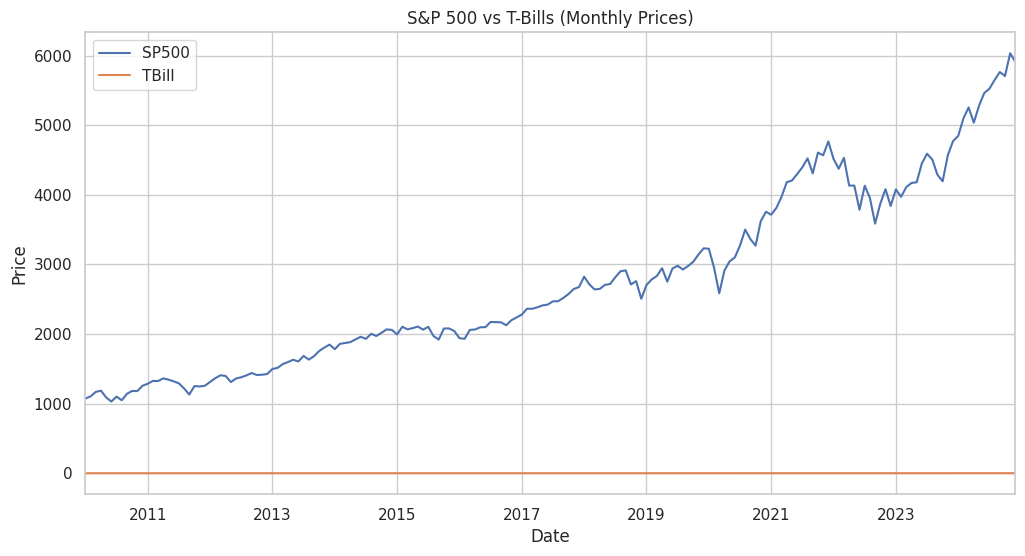

In [18]:
prices.plot(title='S&P 500 vs T-Bills (Monthly Prices)', figsize=(12, 6))
plt.ylabel("Price")
plt.grid(True)
plt.show()

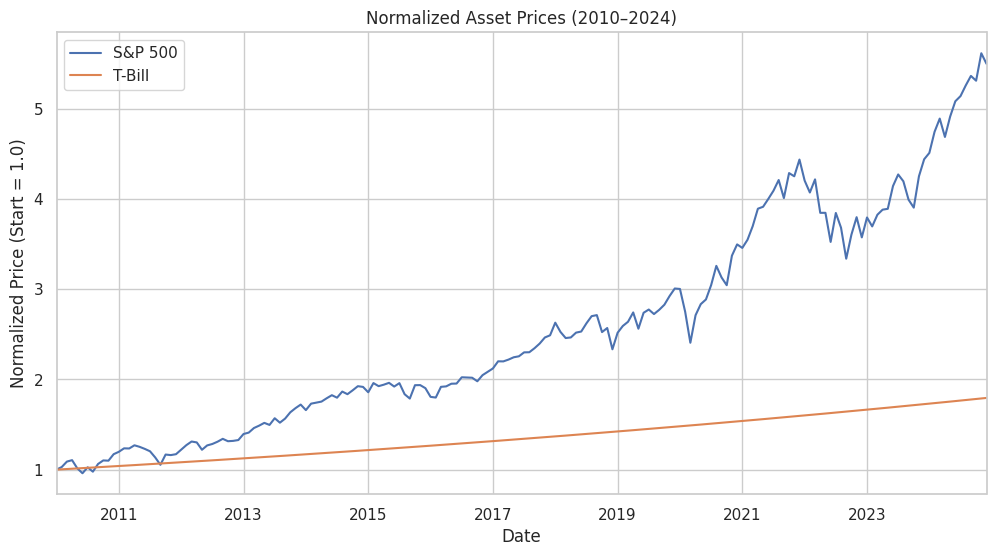

In [19]:
# Normalize both series to start at 1.0
sp500_norm = sp500 / sp500.iloc[0]
tbill_norm = tbill / tbill.iloc[0]

# Combine into a DataFrame for plotting
prices_norm = pd.DataFrame({
    'S&P 500': sp500_norm,
    'T-Bill': tbill_norm
})

# Plot the normalized prices
prices_norm.plot(figsize=(12, 6), title="Normalized Asset Prices (2010–2024)")
plt.ylabel("Normalized Price (Start = 1.0)")
plt.grid(True)
plt.show()

In [28]:
import yfinance as yf
import pandas as pd

# Download price data (S&P 500 adjusted close)
spx = yf.download("^GSPC", start="2010-01-01", auto_adjust=True)
price_data = spx["Close"]

def simulate_portfolio(price_data, rebalance_freq='daily', initial_value=1000, target_weights=(0.3, 0.7)):
    tbill_rate = 0.05  # 5% annual rate
    dates = price_data.index
    dt = 1 / 252
    tbill_growth = (1 + tbill_rate) ** dt

    portfolio_value = []
    stock_value = target_weights[1] * initial_value
    tbill_value = target_weights[0] * initial_value

    last_rebalance = dates[0]

    for t in range(1, len(dates)):
        date = dates[t]
        prev_price = price_data.iloc[t - 1]
        current_price = price_data.iloc[t]
        pct_change = (current_price / prev_price) - 1

        stock_value *= (1 + pct_change)
        tbill_value *= tbill_growth

        if rebalance_freq == 'daily' or \
           (rebalance_freq == 'monthly' and date.month != last_rebalance.month) or \
           (rebalance_freq == 'buy_and_hold' and t == 1):

            total = stock_value + tbill_value
            stock_value = target_weights[1] * total
            tbill_value = target_weights[0] * total
            last_rebalance = date
        print(f"DEBUG @ {date}: stock_value = {stock_value} ({type(stock_value)}), "
      f"tbill_value = {tbill_value} ({type(tbill_value)})")

        portfolio_value.append(stock_value + tbill_value)

    return pd.Series(portfolio_value, index=dates[1:], dtype='float64')

[*********************100%***********************]  1 of 1 completed


In [29]:
daily = simulate_portfolio(price_data, 'daily')
monthly = simulate_portfolio(price_data, 'monthly')
buy_hold = simulate_portfolio(price_data, 'buy_and_hold')

Streaming output truncated to the last 5000 lines.
DEBUG @ 2014-06-10 00:00:00: stock_value = Ticker
^GSPC    1108.425817
dtype: float64 (<class 'pandas.core.series.Series'>), tbill_value = Ticker
^GSPC    469.297007
dtype: float64 (<class 'pandas.core.series.Series'>)
DEBUG @ 2014-06-11 00:00:00: stock_value = Ticker
^GSPC    1104.50527
dtype: float64 (<class 'pandas.core.series.Series'>), tbill_value = Ticker
^GSPC    469.387877
dtype: float64 (<class 'pandas.core.series.Series'>)
DEBUG @ 2014-06-12 00:00:00: stock_value = Ticker
^GSPC    1096.67555
dtype: float64 (<class 'pandas.core.series.Series'>), tbill_value = Ticker
^GSPC    469.478765
dtype: float64 (<class 'pandas.core.series.Series'>)
DEBUG @ 2014-06-13 00:00:00: stock_value = Ticker
^GSPC    1100.113147
dtype: float64 (<class 'pandas.core.series.Series'>), tbill_value = Ticker
^GSPC    469.56967
dtype: float64 (<class 'pandas.core.series.Series'>)
DEBUG @ 2014-06-16 00:00:00: stock_value = Ticker
^GSPC    1101.033617
dtype

KeyboardInterrupt: 

ValueError: setting an array element with a sequence.

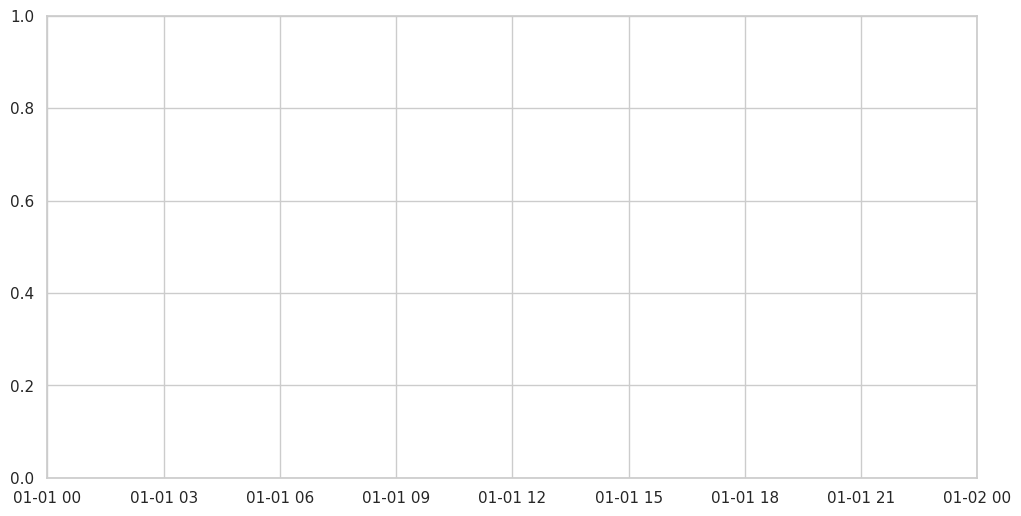

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(daily, label="Daily Rebalance")
plt.plot(monthly, label="Monthly Rebalance")
plt.plot(buy_hold, label="Buy & Hold")
plt.legend()
plt.title("Portfolio Value Comparison")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
import yfinance as yf
import pandas as pd

# Download and flatten the price series
spx = yf.download("^GSPC", start="2010-01-01", auto_adjust=True)
price_data = spx["Close"]

# If the result is still a DataFrame, extract the column manually
if isinstance(price_data, pd.DataFrame):
    price_data = price_data.loc[:, "^GSPC"]  # flatten it

price_data.name = "SPX"  # optional: clean up the Series name

print(type(price_data))        # should be Series
print(price_data.index[:5])    # should be DatetimeIndex, no multi-index
print(price_data.head())       # clean float values

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None)
Date
2010-01-04    1132.989990
2010-01-05    1136.520020
2010-01-06    1137.140015
2010-01-07    1141.689941
2010-01-08    1144.979980
Name: SPX, dtype: float64


In [35]:
daily = simulate_portfolio(price_data, 'daily')
monthly = simulate_portfolio(price_data, 'monthly')
buy_hold = simulate_portfolio(price_data, 'buy_and_hold')

Streaming output truncated to the last 5000 lines.
DEBUG @ 2021-04-09 00:00:00: stock_value = 2119.6259613388183 (<class 'numpy.float64'>), tbill_value = 885.3012208135764 (<class 'numpy.float64'>)
DEBUG @ 2021-04-12 00:00:00: stock_value = 2119.2103475204985 (<class 'numpy.float64'>), tbill_value = 885.4726421374065 (<class 'numpy.float64'>)
DEBUG @ 2021-04-13 00:00:00: stock_value = 2126.192058055989 (<class 'numpy.float64'>), tbill_value = 885.6440966536344 (<class 'numpy.float64'>)
DEBUG @ 2021-04-14 00:00:00: stock_value = 2117.500765951777 (<class 'numpy.float64'>), tbill_value = 885.8155843686872 (<class 'numpy.float64'>)
DEBUG @ 2021-04-15 00:00:00: stock_value = 2140.9927228864317 (<class 'numpy.float64'>), tbill_value = 885.987105288993 (<class 'numpy.float64'>)
DEBUG @ 2021-04-16 00:00:00: stock_value = 2148.7191792929884 (<class 'numpy.float64'>), tbill_value = 886.1586594209815 (<class 'numpy.float64'>)
DEBUG @ 2021-04-19 00:00:00: stock_value = 2137.3168718418956 (<class 

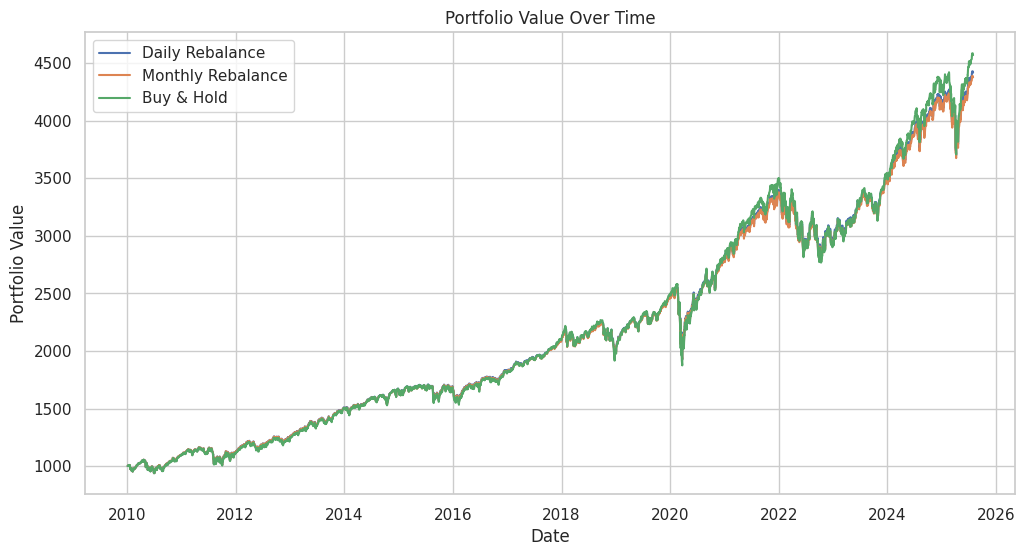

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily, label='Daily Rebalance')
plt.plot(monthly, label='Monthly Rebalance')
plt.plot(buy_hold, label='Buy & Hold')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
import numpy as np

def compute_performance_metrics(portfolio_series, risk_free_rate=0.05):
    returns = portfolio_series.pct_change().dropna()
    total_days = (portfolio_series.index[-1] - portfolio_series.index[0]).days
    years = total_days / 365.25

    # CAGR
    final_value = portfolio_series.iloc[-1]
    initial_value = portfolio_series.iloc[0]
    cagr = (final_value / initial_value) ** (1 / years) - 1

    # Volatility
    vol = returns.std() * np.sqrt(252)

    # Sharpe (risk-free assumed constant)
    excess_return = cagr - risk_free_rate
    sharpe = excess_return / vol if vol != 0 else np.nan

    # Max drawdown
    running_max = portfolio_series.cummax()
    drawdown = portfolio_series / running_max - 1
    max_drawdown = drawdown.min()

    return {
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_drawdown
    }

# Collect all strategies
results = {
    "Daily": compute_performance_metrics(daily),
    "Monthly": compute_performance_metrics(monthly),
    "Buy & Hold": compute_performance_metrics(buy_hold)
}

# Display as DataFrame
performance_df = pd.DataFrame(results).T
performance_df = performance_df.map(lambda x: f"{x:.2%}")
print(performance_df)

              CAGR Volatility Sharpe Ratio Max Drawdown
Daily       10.00%     12.22%       40.89%      -24.56%
Monthly      9.93%     12.08%       40.83%      -24.19%
Buy & Hold  10.24%     13.50%       38.81%      -27.37%
